<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/NegEx_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install stanza
!pip install spacy_stanza
!pip install negspacy
!pip install negex
!pip install negfinder
!pip install negexpander
!pip install spacy-pipeline-negex



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 31.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for negspacy: filename=negspacy-1.0.4-py3-none-any.whl size=12535 sha256=036d1b638637ee4d2d9ec0737503131f5f6ba45759541dadc1e8c055852b0344
  Stored in directory: /root/.cache/pip/wheels/15/31/f0/3a217aaedf320e4df653347cd6538f3648263b864c8e140853
Successfully built negspacy
ERROR: Could not find a version that satisfies the requirement negfinder (from versions: none)
ERROR: No matching distribution found for negfinder
ERROR: Could not find a version that satisfies the requirement negexpander (from versions: none)
ERROR: No matching distribution found for negexpander
ERROR: Could not find a version that satisfies the requirement spacy-pipe

In [3]:
import spacy # to build a nlp pipeline
import stanza # for named entity recognition
# this package wraps Stanza around Spacy, so that we can use Stanza in a spaCy pipeline.
import spacy_stanza
from negspacy.negation import Negex
from negspacy.termsets import termset # to customize negation terms
import pandas as pd
from tqdm.auto import tqdm
nlp = spacy.load("en_core_web_sm")
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load your CSV dataset
df = pd.read_csv("true_positive_experimentation.csv")

## **RBM #1 : NegEx**

In [ ]:
# download and initialize a mimic pipeline with an i2b2 NER model
# stanza.download('en', package='mimic', processors={'ner': 'i2b2'})
nlp = spacy_stanza.load_pipeline('en', package='mimic', processors={'ner': 'i2b2'})

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | mimic   |
| ner       | i2b2    |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
# nlp.add_pipe("negex", config={"ent_types":["PROBLEM","TEST",'TREATMENT']})

ValueError: ignored

In [ ]:
# nlp = spacy.load("en_core_sci_sm")
# import spacy
# from spacy.pipeline.negex import NegexComponent

# nlp = spacy.load("en_core_sci_sm")
# negex = NegexComponent(config={"chunk_prefix": ["no", "none", "not", "nor", "without"]})
# nlp.add_pipe(negex)


In [ ]:
import spacy
import pandas as pd
from tqdm import tqdm

# Load spaCy model with the NegEx component
# nlp = spacy.load("en_core_sci_sm")
# nlp.add_pipe("negex", config={"chunk_prefix": ["no", "none", "not", "nor", "without","lack"]})

# Initialize an empty list to store predictions
predictions = []

# Iterate through the text in your DataFrame
for text in tqdm(df["doc_text_original"]):
    # Process the text with SpaCy
    doc = nlp(text)

    # Initialize a variable to track whether the sentence contains negations
    contains_negation = False

    # Iterate through sentences and check for negations
    for sent in doc.sents:
        for ent in sent.ents:
            if ent._.negex:
                contains_negation = True
                break

    # Determine the final classification (0 for negation, 1 for non-negation)
    prediction = 0 if contains_negation else 1
    predictions.append(prediction)

# Add the predictions as a new column in the dataframe
df['predicted'] = predictions


100%|██████████| 694/694 [00:09<00:00, 75.29it/s]


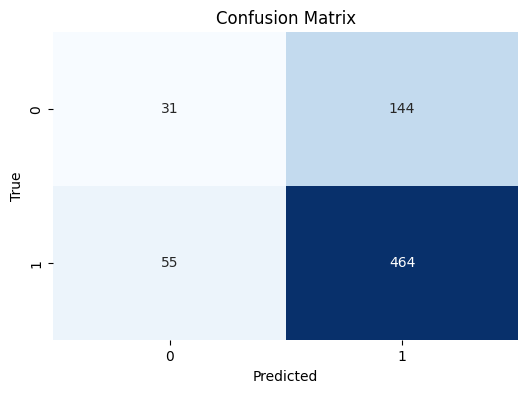

Accuracy: 0.71
Precision: 0.76
Recall: 0.89
F1 Score: 0.82


In [ ]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:
df[["label","selected_sentence"]]

,label,selected_sentence
0,yes,The Statfjord reservoir is overpressured (emw ...
1,yes,‘ The Brent reservoir is overpressured (emw 1...
2,yes,"» Finally, the core measurements have not been..."
3,yes,Also if the pressure in the Lower Unit should ...
4,yes,As regards the two pressures obtained in the w...
...,...,...
689,yes,"wide , ft , dull , yelwh t/t 20 % patchy grny/..."
690,yes,however no toc data avocet 1a and lorikeer 1 o...
691,yes,however no toc data avocet 1a and lorikeer 1 o...
692,yes,lower levels of these unknown compounds is not...


## **RBM #2 : Filter with negation terms**

In [ ]:
import spacy
import pandas as pd

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

# Define the negation terms
negation_terms = ["no", "none", "not", "nor", "without"]

# Your DataFrame (replace this with your actual DataFrame)
# df = pd.read_csv("your_dataset.csv")

# Define a function for negation detection
def detect_negation(text):
    # Process the text with SpaCy
    doc = nlp(text)

    # Initialize a variable to track whether negation is detected
    negation_detected = False

    # Iterate through the tokens and check for negation terms
    for token in doc:
        if token.text.lower() in negation_terms:
            negation_detected = True
            break

    return negation_detected

# Apply the negation detection function to each text in the DataFrame
df["predicted"] = df["doc_text_original"].apply(detect_negation)

# Map the negation detection result to 0 (negation) or 1 (non-negation)
df["predicted"] = df["predicted"].astype(int)



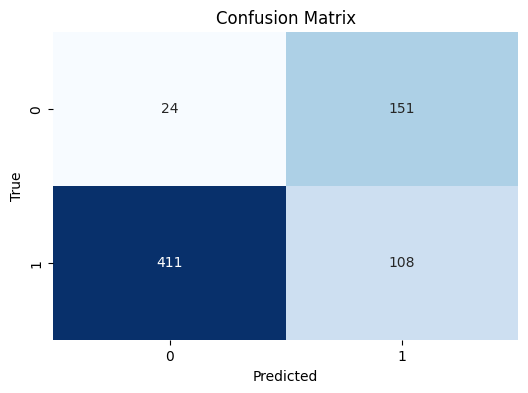

Accuracy: 0.19
Precision: 0.42
Recall: 0.21
F1 Score: 0.28


In [ ]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


## **RBM #3 : Deterministic Option**

In [4]:
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

# Load your CSV dataset
df = pd.read_csv("true_positive_experimentation.csv")

## **Unit Test Text**

In [8]:
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')

# Define the topics as flexible terms (subwords or whole words)
topics = ["overpressure", "sand production", "oil show"]

# Define the negation terms pattern with case-insensitivity
negation_terms = r'(?i)(?:(?<=\s)|^)(no|none|not|nor|without)(?=\s|$)'

# Initialize a WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a custom lemmatization rule to replace "ized" with "e"
def custom_lemmatizer(word):
    if word.endswith("ized"):
        return re.sub(r'ized$', 'e', word)
    else:
        return lemmatizer.lemmatize(word)

# Initialize a list to store selected sentences
selected_sentences_1 = []

# Sample text
input_text = "	the overpressured zone. This would also explain why no indication of the impending overpressure zone was noticed while drilling this section. Once within the overpressured zone the static mud weight was below pore pressure. This under any normal circumstances would have resulted in flow into the well '"

# Convert the text to lowercase
text = input_text.lower()  # Convert to lowercase

# Tokenize the text into sentences using NLTK's sent_tokenize
sentences = sent_tokenize(text)

# Initialize a flag to check for both topic terms and negation terms
both_detected = False


if len(sentences) == 1:
    # If there is only one sentence, append the entire text

    selected_sentences_1.append(text)
else:
    for sentence in sentences:


      # Initialize a flag to check if any topic term is found in the sentence
      topic_found = False

      # Tokenize the sentence into words
      words = word_tokenize(sentence)

      # Lemmatize each word using the custom lemmatizer
      lemmatized_words = [custom_lemmatizer(word) for word in words]

      # Join the lemmatized words back into a sentence
      lemmatized_sentence = ' '.join(lemmatized_words)

      # Check if the sentence contains any of the specified topics (partial matches)
      for topic in topics:
          if topic in lemmatized_sentence.lower():  # Convert to lowercase for matching
              topic_found = True
              break

      # Check if the lemmatized sentence contains negation terms
      if re.search(negation_terms, lemmatized_sentence.lower()):
          negation_detected = True
      else:
          negation_detected = False

      # If a topic term is found and either no negation terms are found or negation_detected is False, append the sentence
      if (topic_found is True) and (negation_detected is True):
          selected_sentences_1.append(lemmatized_sentence)
          both_detected = True


      elif (topic_found is True) and (negation_detected is False):
          selected_sentences_1.append(lemmatized_sentence)
          both_detected = True



    # If no suitable sentence is found, set 'None' as a placeholder
    if not both_detected:
        selected_sentences_1.append(None)

# Determine the prediction (0 or 1) based on the presence of negation terms in selected_sentence_1
# selected_sentence = selected_sentences_1[0]

neg = ["no", "not", "lack", "nor" , "none" , "without", "rather than"]

if len(selected_sentences_1) != 1:
  for text in selected_sentences_1:
    for items in neg:
      if items in text:
        selected_sentence = text

else:
  selected_sentence = selected_sentences_1
  selected_sentence = selected_sentence[0]



if selected_sentence is not None:
    # Check if the lemmatized sentence contains negation terms
    if re.search(negation_terms, selected_sentence.lower()):
        prediction = 0  # Negation terms found, set the prediction to 0
    else:
        prediction = 1  # No negation terms found, set the prediction to 1
else:
    prediction = 0  # Handle the case where selected_sentence is None

# Print the selected sentence and prediction
print("Selected Sentence:", selected_sentence)
print("Prediction:", prediction)


Selected Sentence: this would also explain why no indication of the impending overpressure zone wa noticed while drilling this section .
Prediction: 0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Dataframe test**

In [14]:
import re
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')

# Define the topics as flexible terms (subwords or whole words)
topics = ["overpressure", "sand production", "oil show"]

# Define the negation terms pattern with case-insensitivity
negation_terms = r'(?i)(?:(?<=\s)|^)(no|none|not|nor|without|rather)(?=\s|$)'

# Initialize a WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a custom lemmatization rule to replace "ized" with "e"
def custom_lemmatizer(word):
    if word.endswith("ized"):
        return re.sub(r'ized$', 'e', word)
    elif word.endswith("ing"):
        return re.sub(r'ing$', 'e', word)
    else:
        return lemmatizer.lemmatize(word)

# Initialize a list to store selected sentences
selected_sentences = []

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    text = row['doc_text_original'].lower()  # Convert to lowercase

    # Tokenize the text into sentences using NLTK's sent_tokenize
    sentences = sent_tokenize(text)

    # Initialize flags to check for both topic terms and negation terms
    topic_found = False
    negation_detected = False

    for sentence in sentences:
        # Tokenize the sentence into words
        words = word_tokenize(sentence)

        # Lemmatize each word using the custom lemmatizer
        lemmatized_words = [custom_lemmatizer(word) for word in words]

        # Join the lemmatized words back into a sentence
        lemmatized_sentence = ' '.join(lemmatized_words)

        # Check if the sentence contains any of the specified topics (partial matches)
        for topic in topics:
            if topic in lemmatized_sentence.lower():  # Convert to lowercase for matching
                topic_found = True
                break

        # Check if the lemmatized sentence contains negation terms
        if re.search(negation_terms, lemmatized_sentence.lower()):
            negation_detected = True

        # If both topic and negation terms are found, append the sentence
        if topic_found and negation_detected:
            selected_sentences.append(lemmatized_sentence)
            break

    # If no sentence with both topic and negation terms is found, append the first sentence without a negation term
    if not topic_found or not negation_detected:
        for sentence in sentences:
            if not re.search(negation_terms, sentence.lower()):
                selected_sentences.append(sentence)
                break

# Add the selected_sentences as a new column named 'selected_sentence'
df['selected_sentence'] = selected_sentences

# Determine the prediction (0 or 1) based on the presence of negation terms in selected_sentence
for index, row in df.iterrows():
    selected_sentence = row['selected_sentence']

    if selected_sentence is not None:
        # Check if the lemmatized sentence contains negation terms
        if re.search(negation_terms, selected_sentence.lower()):
            prediction = 0  # Negation terms found, set the prediction to 0
        else:
            prediction = 1  # No negation terms found, set the prediction to 1
    else:
        prediction = 0  # Handle the case where selected_sentence is None

    df.at[index, 'predicted'] = prediction

# Print the DataFrame with the 'label' column
df[['doc_text_original', 'selected_sentence', 'label_code', 'predicted']]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,doc_text_original,selected_sentence,label_code,predicted
0,The Statfjord reservoir is overpressured (emw ...,the statfjord reservoir is overpressured (emw ...,1,1.0
1,‘ The Brent reservoir is overpressured (emw 1...,‘ the brent reservoir is overpressured (emw 1...,1,1.0
2,"» Finally, the core measurements have not been...",this would somewhat reduce the porosity value ...,1,1.0
3,Also if the pressure in the Lower Unit should ...,also if the pressure in the lower unit should ...,1,1.0
4,As regards the two pressures obtained in the w...,as regards the two pressures obtained in the w...,1,1.0
...,...,...,...,...
689,21 21A 22 22A 23 23A 24 24A 25 25A 26 26A 27 2...,"wide , ft , dull , yelwh t/t 20 % patchy grny/...",1,0.0
690,"""used to calculate the geochemical Altbough th...","however , these two the % sc2 % nor sterane ma...",1,0.0
691,"""used to calculate the geochemical Altbough th...","however , these two the % sc2 % nor sterane ma...",1,0.0
692,lower levels of these unknown compounds is not...,result suggest that the sample represents an o...,1,1.0


In [220]:
"""
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')

# Define the topics as flexible terms (subwords or whole words)
topics = ["overpressure", "sand production", "oil show"]

# Define the negation terms pattern with case-insensitivity
negation_terms = r'(?i)(?:(?<=\s)|^)(no|none|not|nor|without)(?=\s|$)'

# Initialize a WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a custom lemmatization rule to replace "ized" with "e"
def custom_lemmatizer(word):
    if word.endswith("ized"):
        return re.sub(r'ized$', 'e', word)
    else:
        return lemmatizer.lemmatize(word)

# Initialize a list to store predictions
predictions = []

# Initialize a list to store selected sentences
selected_sentences_1 = []

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    # Convert the text to lowercase
    text = row['doc_text_original'].lower()  # Convert to lowercase

    # Tokenize the text into sentences using NLTK's sent_tokenize
    sentences = sent_tokenize(text)

    # Initialize a flag to check for both topic terms and negation terms
    both_detected = False

    if len(sentences) == 1:
    # If there is only one sentence, append the entire text

      selected_sentences_1.append(text)

    else:
        for sentence in sentences:


          # Initialize a flag to check if any topic term is found in the sentence
          topic_found = False

          # Tokenize the sentence into words
          words = word_tokenize(sentence)

          # Lemmatize each word using the custom lemmatizer
          lemmatized_words = [custom_lemmatizer(word) for word in words]

          # Join the lemmatized words back into a sentence
          lemmatized_sentence = ' '.join(lemmatized_words)

          # Check if the sentence contains any of the specified topics (partial matches)
          for topic in topics:
              if topic in lemmatized_sentence.lower():  # Convert to lowercase for matching
                  topic_found = True
                  break

          # Check if the lemmatized sentence contains negation terms
          if re.search(negation_terms, lemmatized_sentence.lower()):
              negation_detected = True
          else:
              negation_detected = False

          # If a topic term is found and either no negation terms are found or negation_detected is False, append the sentence
          if (topic_found is True) and (negation_detected is True):
              selected_sentences_1.append(lemmatized_sentence)
              both_detected = True
              break

          # elif (topic_found is True) and (negation_detected is False):
          #     selected_sentences_1.append(lemmatized_sentence)
          #     both_detected =



    # If no suitable sentence is found, set 'None' as a placeholder
    if not both_detected:
        selected_sentences_1.append(None)
print(selected_sentences_1)

# for multiple negation sentence in a text holder
neg = ["no", "not", "lack", "nor" , "none" , "without"]

if len(selected_sentences_1) != 1:
  for text in selected_sentences_1:
    if text is not None:
      for items in neg:
        if items in text:
          selected_sentence = text
    else:
      selected_sentence = None

else:
  selected_sentence = selected_sentences_1

# print(selected_sentence)

if selected_sentence is not None:
    # Check if the lemmatized sentence contains negation terms
    if re.search(negation_terms, selected_sentence.lower()):
        prediction = 0  # Negation terms found, set the prediction to 0
    else:
        prediction = 1  # No negation terms found, set the prediction to 1
else:
    prediction = 0  # Handle the case where selected_sentence is None

    predictions.append(prediction)


# Add the final predictions as a new column 'predicted'
# df['predicted'] = predictions
"""

'\nimport pandas as pd\nimport re\nimport nltk\nfrom nltk.tokenize import sent_tokenize, word_tokenize\nfrom nltk.stem import WordNetLemmatizer\n\nnltk.download(\'punkt\')\nnltk.download(\'wordnet\')\n\n# Define the topics as flexible terms (subwords or whole words)\ntopics = ["overpressure", "sand production", "oil show"]\n\n# Define the negation terms pattern with case-insensitivity\nnegation_terms = r\'(?i)(?:(?<=\\s)|^)(no|none|not|nor|without)(?=\\s|$)\'\n\n# Initialize a WordNet lemmatizer\nlemmatizer = WordNetLemmatizer()\n\n# Define a custom lemmatization rule to replace "ized" with "e"\ndef custom_lemmatizer(word):\n    if word.endswith("ized"):\n        return re.sub(r\'ized$\', \'e\', word)\n    else:\n        return lemmatizer.lemmatize(word)\n\n# Initialize a list to store predictions\npredictions = []\n\n# Initialize a list to store selected sentences\nselected_sentences_1 = []\n\n# Iterate through each row of the DataFrame\nfor index, row in df.iterrows():\n    # Convert

In [252]:
# Calculate the number of empty cells in the 'selected_sentence_1' column
empty_cells_count = df['selected_sentences'].isna().sum()

print(f"Number of empty cells in 'selected_sentences': {empty_cells_count}")


KeyError: ignored

In [1]:
# Print the DataFrame with the 'label' column
df[['doc_text_original','selected_sentences','label_code','predicted']]



NameError: ignored

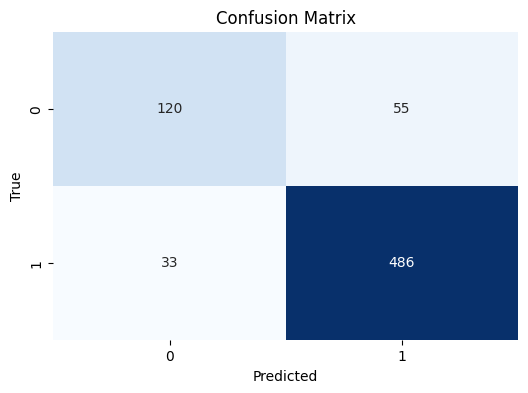

Accuracy: 0.87
Precision: 0.90
Recall: 0.94
F1 Score: 0.92


In [254]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [7]:
# Save the updated dataframe to a new CSV file
df.to_csv("your_updated_dataset.csv", index=False)